In [1]:
import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt

### I/O

In [2]:
FIGURE_SAVEPATH = "../../../figures/"
TYPE1_ERROR_SAVEPATH = "../../../output/type1_errors/"
SAVELABEL = "bart"

SAVE = True

### Formatting

In [3]:
method_cmap = {("Chiseling", 0): "#FF590D",
               ("Chiseling", 1): "#2032DA",
               "DataSplittingStrategy": "#FF9900",
               "SimulDataSplittingStrategy": "#69C1B9",
               "OracleStrategy": "#FF9900",
               "OracleSimulStrategy": "#69C1B9",
               "TTestStrategy": "#E70202"}
method_pretty_name_map = {("Chiseling", 0): "NONAME",
                          ("Chiseling", 1): "Chiseling",
                          "DataSplittingStrategy": "Data Splitting",
                          "SimulDataSplittingStrategy": "Simul. Data Splitting",
                          "OracleStrategy": "Oracle",
                          "OracleSimulStrategy": "Simul. Oracle",
                          "TTestStrategy": r"Global $t$-test"}
full_method_pretty_name_map = {("Chiseling", 0): "Chiseling (Single)",
                               ("Chiseling", 1): "Chiseling (Multiple)",
                               "DataSplittingStrategy": "Data Splitting",
                               "SimulDataSplittingStrategy": "Simul. Data Splitting",
                               "OracleStrategy": "Oracle",
                               "OracleSimulStrategy": "Simul. Oracle",
                               "TTestStrategy": r"Global $t$-test"}

MARKERSIZE = 150
LABEL_FONTSIZE = 28
TITLE_FONTSIZE = 32
LEGEND_FONTSIZE = 24
TICK_FONTSIZE = 24
HIDESPINES = True
LINEWIDTH = 4

BONF_LINESTYLE = "--"
ORACLE_LINESTYLE = (0, (1, 1))
ORACLE_LEGEND_COLOR = "#787E93"
BONF_LEGEND_COLOR = "#787E93"
BONF_LABEL_NAME = "Bonf. Agg."
ORACLE_LABEL_NAME = "Oracle"

### Preprocessing

In [4]:
task_array_path = "../../task_arrays/bart_analysis.tasks.tsv"
res_path = "../../../output/bart_analysis/bart_analysis.combined.tsv"

In [5]:
task_df = pd.read_csv(task_array_path, sep="\t", index_col=None)
res_df = pd.read_csv(res_path, sep="\t", index_col=None)
# Merge task meta and results
res_df = res_df.merge(task_df, how="left", on="task_id")

### Aggregate

In [6]:
setting_identifiers = ["test_thresh", "strategy", "n_burn_in", "train_ratio",
                       "bonf_strategy", "margin_width"]
agg_res_df = res_df.groupby(setting_identifiers, dropna=False)[["rejected", "subgroup_utility", "region_mass"]].agg(["mean", "var", "count"])
agg_res_df.columns = ["_".join(c) for c in agg_res_df.columns.to_flat_index()]
agg_res_df = agg_res_df.reset_index()
agg_res_df["rejected_se"] = np.sqrt(agg_res_df.rejected_var / agg_res_df.rejected_count)
agg_res_df["subgroup_utility_se"] = np.sqrt(agg_res_df.subgroup_utility_var / agg_res_df.subgroup_utility_count)
agg_res_df["region_mass_se"] = np.sqrt(agg_res_df.region_mass_var / agg_res_df.region_mass_count)
agg_res_df = agg_res_df.loc[:,setting_identifiers + ["rejected_mean", "rejected_se",
                                                     "subgroup_utility_mean", "subgroup_utility_se",
                                                     "region_mass_mean", "region_mass_se"]]

### Settings

In [7]:
# DGP
test_thresh_n_space = [(0.3,500),
                       (0.35,1500),
                       (0.4,6000),
                       (0.45,10000)]
# Chiseling
n_burn_in_space = np.round(np.linspace(0.1,0.9,9), 4)
margin_width_settings = [0, 1]
viz_margin_width_settings = [1]

# Data split
train_ratio_space = np.round(np.linspace(0.1,0.9,9), 4)

### Visualizations

Expected utility

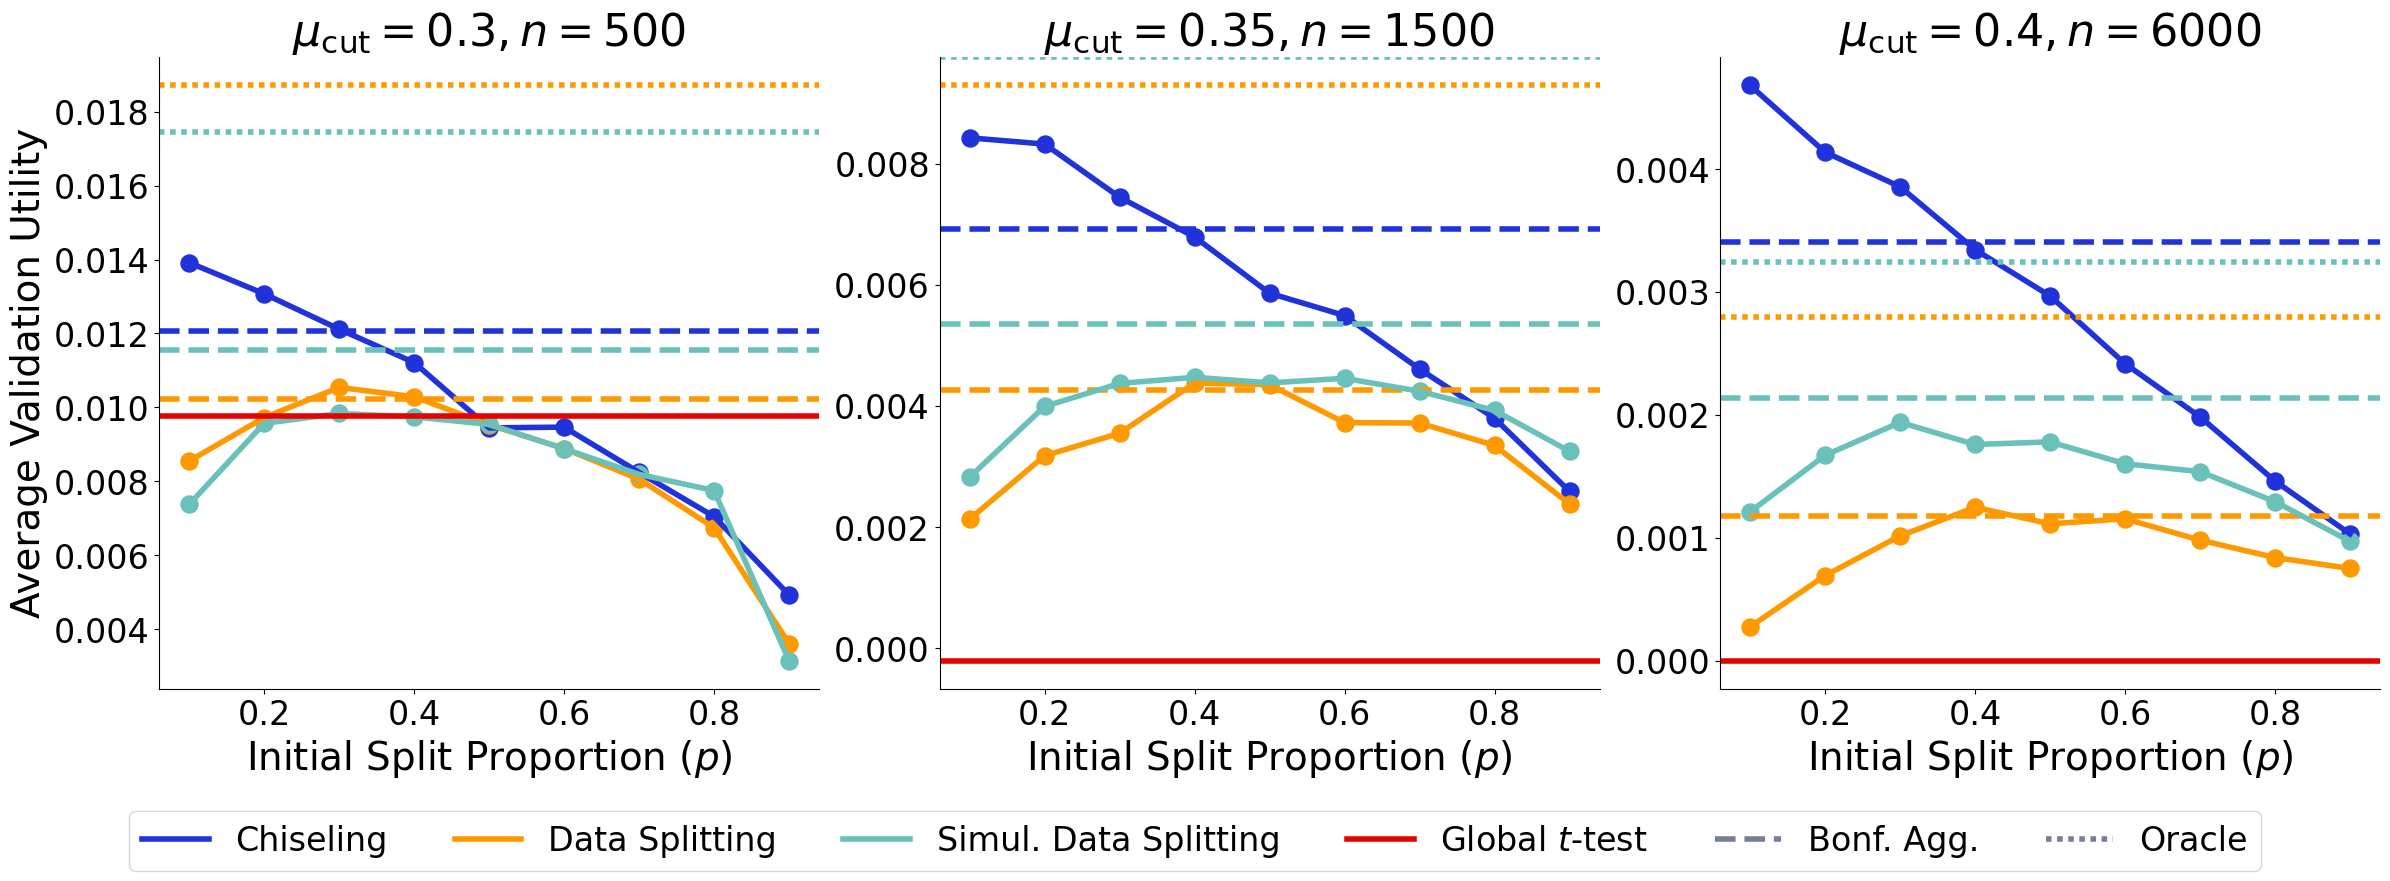

In [8]:
fig, ax = plt.subplots(1,3,figsize=(24,8))

VIZ_PROPERTY = "subgroup_utility_mean"
YLABEL = "Average Validation Utility"
PLOT_SAVELABEL = "utility"

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for test_thresh, n in test_thresh_n_space[:3]:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.test_thresh == test_thresh]
    # Chiseling methods
    for margin_width in viz_margin_width_settings:
        color = method_cmap[("Chiseling", margin_width)]
        method_pretty_name = method_pretty_name_map[("Chiseling", margin_width)]
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                     label=method_pretty_name, color=color, linewidth=LINEWIDTH)
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                        color=color, s=MARKERSIZE)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH,
                        linestyle=BONF_LINESTYLE)
    # Data splitting
    color = method_cmap["DataSplittingStrategy"]
    method_pretty_name = method_pretty_name_map["DataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "DataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "DataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH,
                    linestyle=BONF_LINESTYLE)
    # Simultaneous data splitting
    color = method_cmap["SimulDataSplittingStrategy"]
    method_pretty_name = method_pretty_name_map["SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for simultaneous data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "SimulDataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH,
                    linestyle=BONF_LINESTYLE)
    # T-test
    color = method_cmap["TTestStrategy"]
    method_pretty_name = method_pretty_name_map["TTestStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "TTestStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    # Oracle
    color = method_cmap["OracleStrategy"]
    method_pretty_name = method_pretty_name_map["OracleStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    linestyle=ORACLE_LINESTYLE, color=color, linewidth=LINEWIDTH)
    # Oracle simultaneous
    color = method_cmap["OracleSimulStrategy"]
    method_pretty_name = method_pretty_name_map["OracleSimulStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleSimulStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    linestyle=ORACLE_LINESTYLE, color=color, linewidth=LINEWIDTH)
    # Add title
    ax[AX0].set_title(r"$\mu_{\mathrm{cut}}" + "= {}, n = {}$".format(test_thresh, n), fontsize=TITLE_FONTSIZE)
    # Set x-labels
    ax[AX0].set_xlabel("Initial Split Proportion ($p$)", fontsize=LABEL_FONTSIZE)
    # Tick fontsize
    ax[AX0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    if HIDESPINES:
        ax[AX0].spines[['right', 'top']].set_visible(False)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

# Add some invisible dummy data to distinguish linestyles in plot
# Bonferroni linestyle
ax[0].plot(0.5, 0.01, color=BONF_LEGEND_COLOR, linestyle=BONF_LINESTYLE, linewidth=LINEWIDTH, label=BONF_LABEL_NAME)
# Oracle linestyle
ax[0].plot(0.5, 0.01, color=ORACLE_LEGEND_COLOR, linestyle=ORACLE_LINESTYLE, linewidth=LINEWIDTH, label=ORACLE_LABEL_NAME)

# Global formatting
ax[0].set_ylabel(YLABEL, fontsize=LABEL_FONTSIZE)
# ax[-1].legend(fontsize=LEGEND_FONTSIZE)
handles, _ = ax[0].get_legend_handles_labels()
fig.legend(handles=handles, fontsize=LEGEND_FONTSIZE, loc='upper center',
           bbox_to_anchor=(0.5, 0), fancybox=True, ncols=6)
plt.tight_layout()

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "{}.{}.pdf".format(SAVELABEL, PLOT_SAVELABEL), bbox_inches="tight", dpi=300)

plt.show()

Power

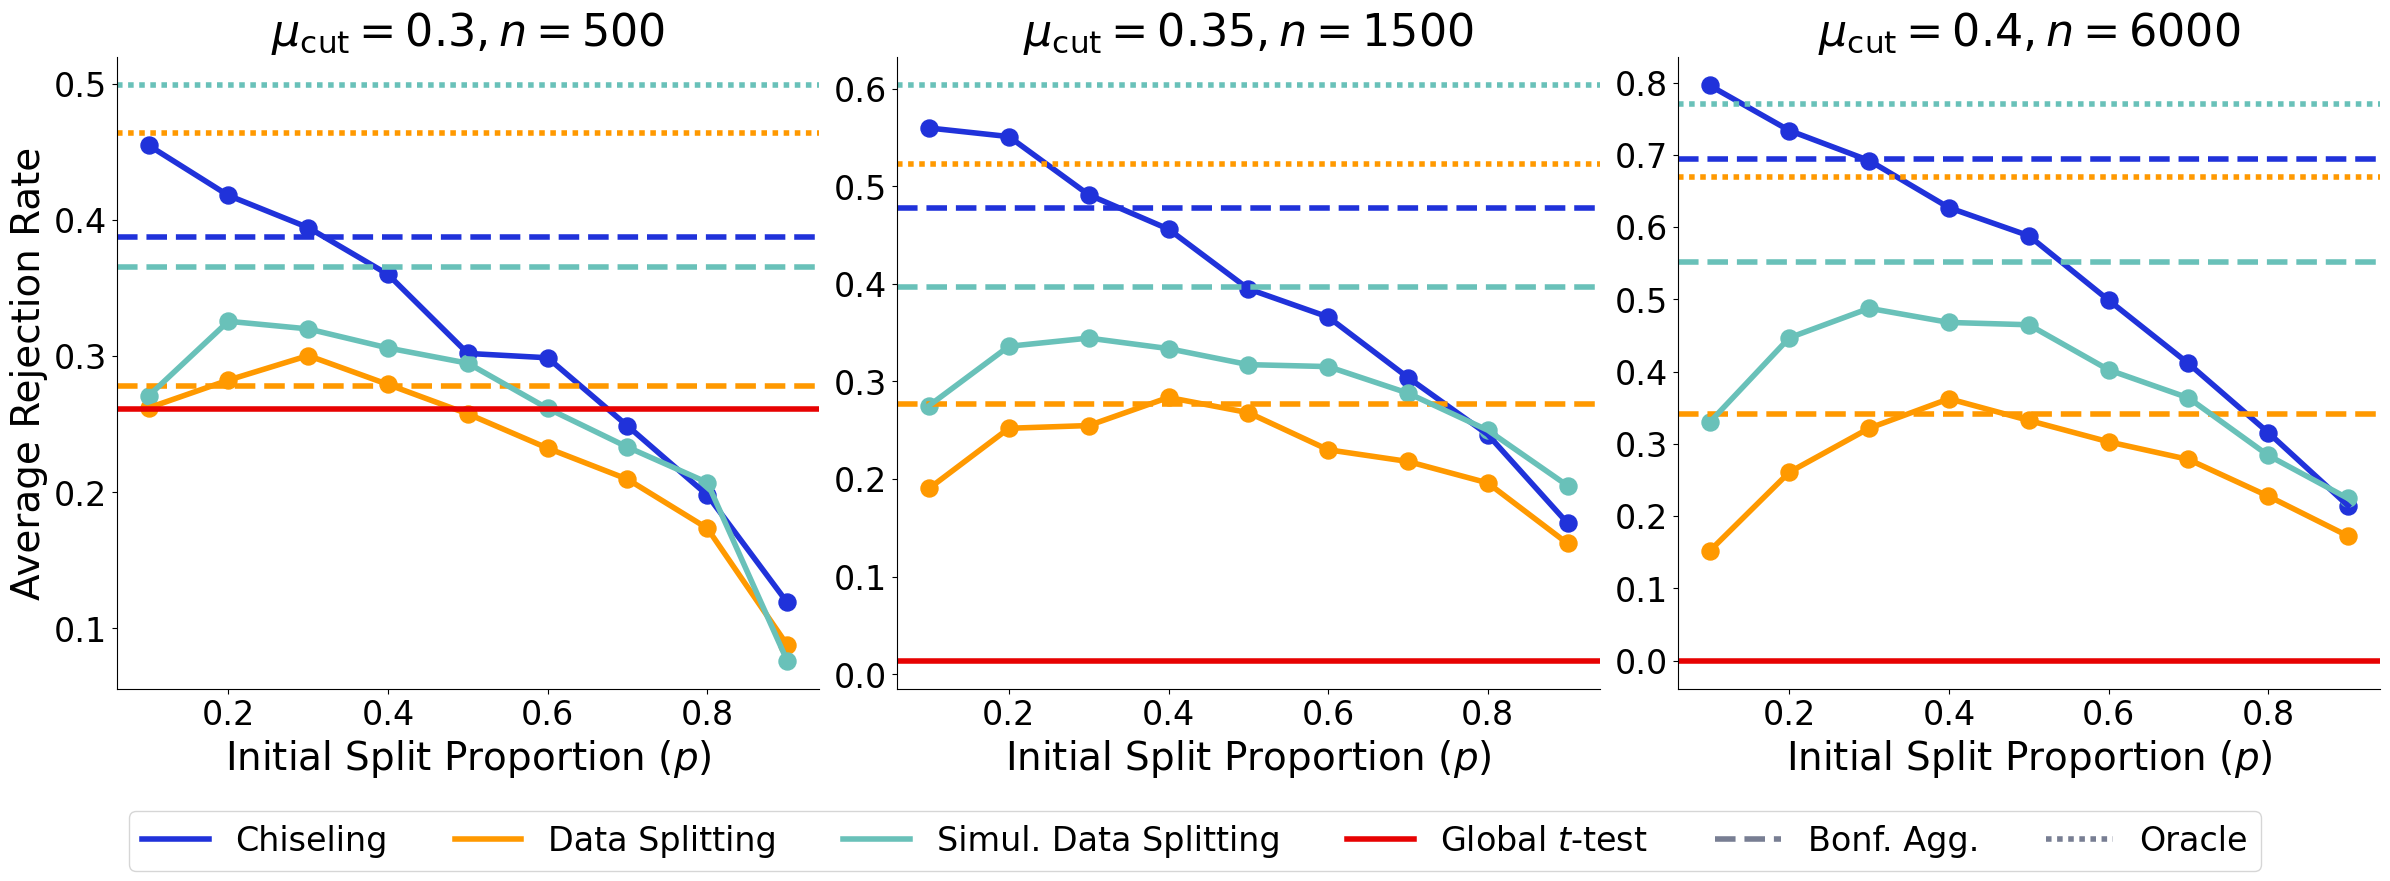

In [9]:
fig, ax = plt.subplots(1,3,figsize=(24,8))

VIZ_PROPERTY = "rejected_mean"
YLABEL = "Average Rejection Rate"
PLOT_SAVELABEL = "power"

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for test_thresh, n in test_thresh_n_space[:3]:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.test_thresh == test_thresh]
    # Chiseling methods
    for margin_width in viz_margin_width_settings:
        color = method_cmap[("Chiseling", margin_width)]
        method_pretty_name = method_pretty_name_map[("Chiseling", margin_width)]
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                     label=method_pretty_name, color=color, linewidth=LINEWIDTH)
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                        color=color, s=MARKERSIZE)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH,
                        linestyle=BONF_LINESTYLE)
    # Data splitting
    color = method_cmap["DataSplittingStrategy"]
    method_pretty_name = method_pretty_name_map["DataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "DataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "DataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH,
                    linestyle=BONF_LINESTYLE)
    # Simultaneous data splitting
    color = method_cmap["SimulDataSplittingStrategy"]
    method_pretty_name = method_pretty_name_map["SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for simultaneous data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "SimulDataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH,
                    linestyle=BONF_LINESTYLE)
    # T-test
    color = method_cmap["TTestStrategy"]
    method_pretty_name = method_pretty_name_map["TTestStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "TTestStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    # Oracle
    color = method_cmap["OracleStrategy"]
    method_pretty_name = method_pretty_name_map["OracleStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    linestyle=ORACLE_LINESTYLE, color=color, linewidth=LINEWIDTH)
    # Oracle simultaneous
    color = method_cmap["OracleSimulStrategy"]
    method_pretty_name = method_pretty_name_map["OracleSimulStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleSimulStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    linestyle=ORACLE_LINESTYLE, color=color, linewidth=LINEWIDTH)
    # Add title
    ax[AX0].set_title(r"$\mu_{\mathrm{cut}}" + "= {}, n = {}$".format(test_thresh, n), fontsize=TITLE_FONTSIZE)
    # Set x-labels
    ax[AX0].set_xlabel("Initial Split Proportion ($p$)", fontsize=LABEL_FONTSIZE)
    # Tick fontsize
    ax[AX0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    if HIDESPINES:
        ax[AX0].spines[['right', 'top']].set_visible(False)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

# Add some invisible dummy data to distinguish linestyles in plot
# Bonferroni linestyle
ax[0].plot(0.5, 0.3, color=BONF_LEGEND_COLOR, linestyle=BONF_LINESTYLE, linewidth=LINEWIDTH, label=BONF_LABEL_NAME)
# Oracle linestyle
ax[0].plot(0.5, 0.3, color=ORACLE_LEGEND_COLOR, linestyle=ORACLE_LINESTYLE, linewidth=LINEWIDTH, label=ORACLE_LABEL_NAME)

# Global formatting
ax[0].set_ylabel(YLABEL, fontsize=LABEL_FONTSIZE)
# ax[-1].legend(fontsize=LEGEND_FONTSIZE)
handles, _ = ax[0].get_legend_handles_labels()
fig.legend(handles=handles, fontsize=LEGEND_FONTSIZE, loc='upper center',
           bbox_to_anchor=(0.5, 0), fancybox=True, ncols=6)
plt.tight_layout()

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "{}.{}.pdf".format(SAVELABEL, PLOT_SAVELABEL), bbox_inches="tight", dpi=300)

plt.show()

Size

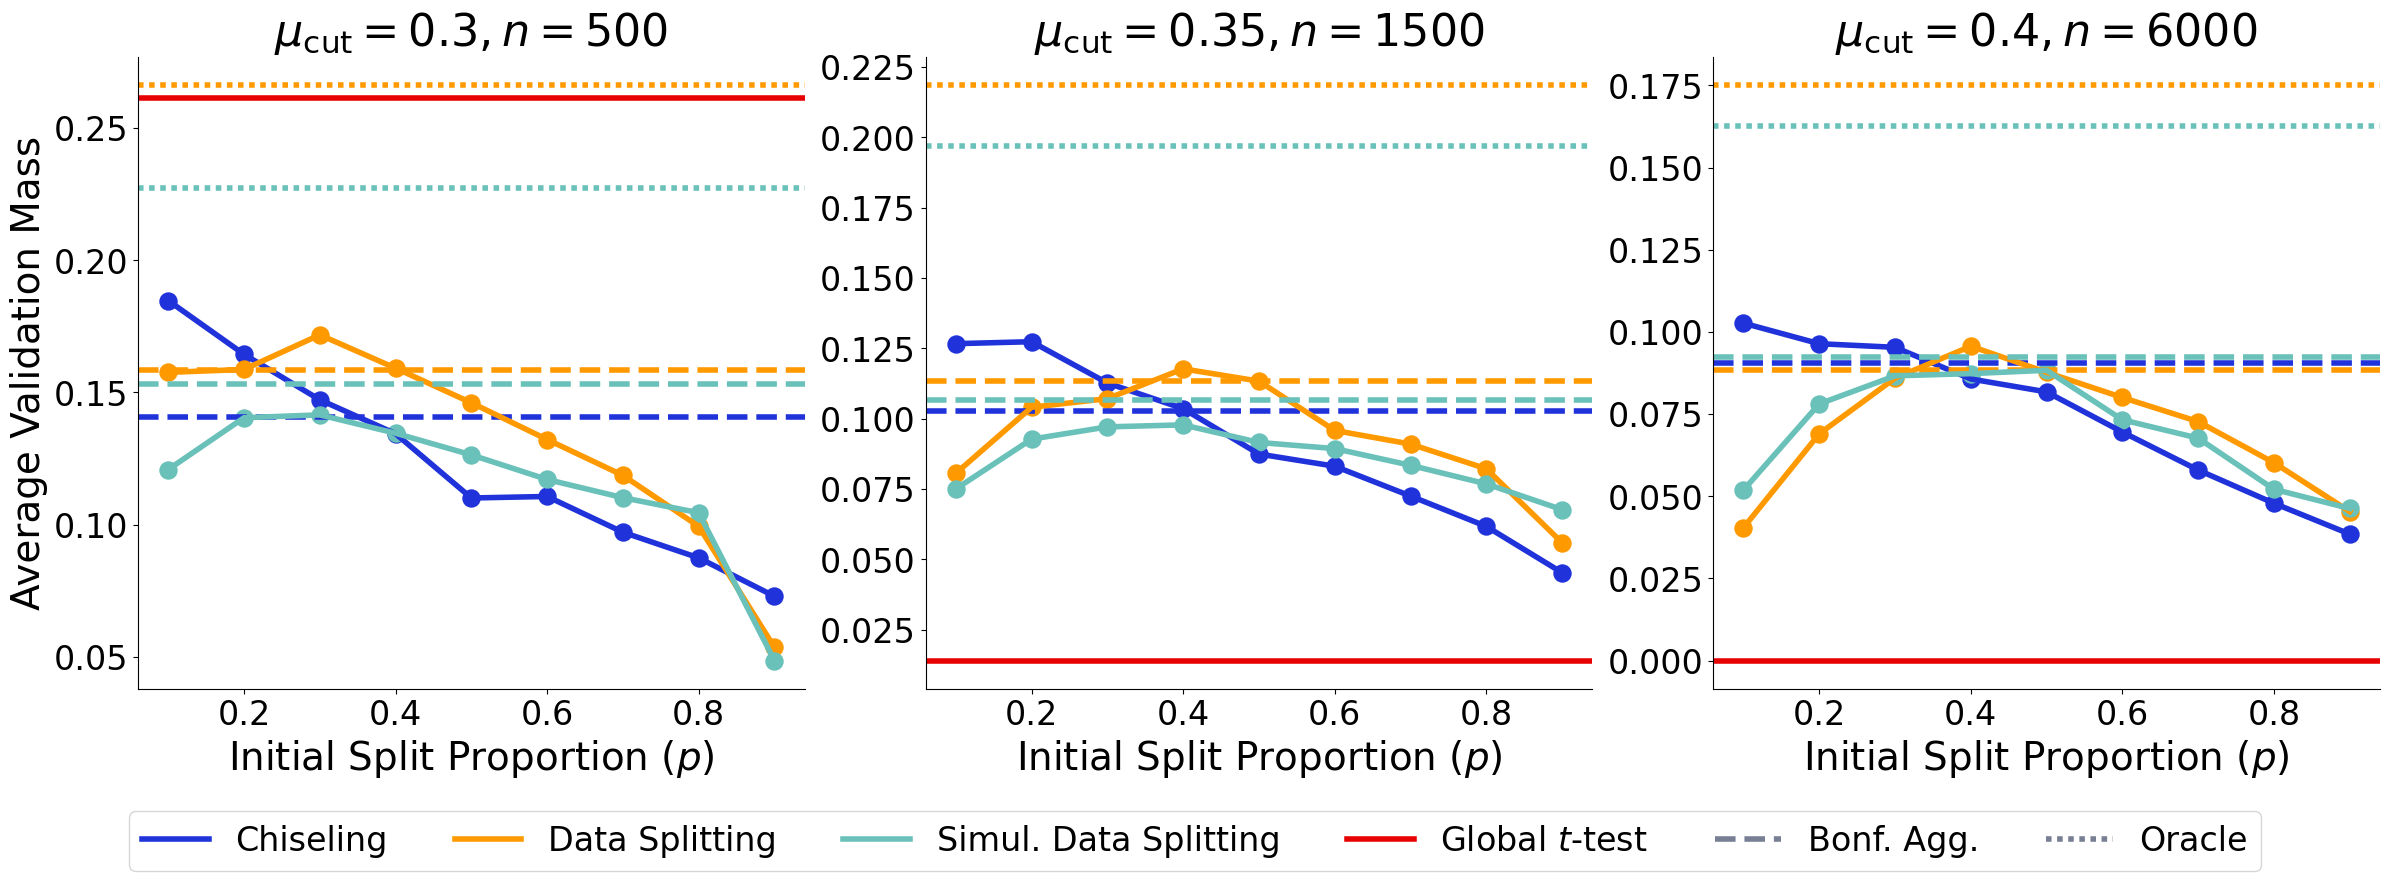

In [10]:
fig, ax = plt.subplots(1,3,figsize=(24,8))

VIZ_PROPERTY = "region_mass_mean"
YLABEL = "Average Validation Mass"
PLOT_SAVELABEL = "size"

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for test_thresh, n in test_thresh_n_space[:3]:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.test_thresh == test_thresh]
    # Chiseling methods
    for margin_width in viz_margin_width_settings:
        color = method_cmap[("Chiseling", margin_width)]
        method_pretty_name = method_pretty_name_map[("Chiseling", margin_width)]
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                     label=method_pretty_name, color=color, linewidth=LINEWIDTH)
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                        color=color, s=MARKERSIZE)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH,
                        linestyle=BONF_LINESTYLE)
    # Data splitting
    color = method_cmap["DataSplittingStrategy"]
    method_pretty_name = method_pretty_name_map["DataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "DataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "DataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH,
                    linestyle=BONF_LINESTYLE)
    # Simultaneous data splitting
    color = method_cmap["SimulDataSplittingStrategy"]
    method_pretty_name = method_pretty_name_map["SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for simultaneous data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "SimulDataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH,
                    linestyle=BONF_LINESTYLE)
    # T-test
    color = method_cmap["TTestStrategy"]
    method_pretty_name = method_pretty_name_map["TTestStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "TTestStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    # Oracle
    color = method_cmap["OracleStrategy"]
    method_pretty_name = method_pretty_name_map["OracleStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    linestyle=ORACLE_LINESTYLE, color=color, linewidth=LINEWIDTH)
    # Oracle simultaneous
    color = method_cmap["OracleSimulStrategy"]
    method_pretty_name = method_pretty_name_map["OracleSimulStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleSimulStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    linestyle=ORACLE_LINESTYLE, color=color, linewidth=LINEWIDTH)
    # Add title
    ax[AX0].set_title(r"$\mu_{\mathrm{cut}}" + "= {}, n = {}$".format(test_thresh, n), fontsize=TITLE_FONTSIZE)
    # Set x-labels
    ax[AX0].set_xlabel("Initial Split Proportion ($p$)", fontsize=LABEL_FONTSIZE)
    # Tick fontsize
    ax[AX0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    if HIDESPINES:
        ax[AX0].spines[['right', 'top']].set_visible(False)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

# Add some invisible dummy data to distinguish linestyles in plot
# Bonferroni linestyle
ax[0].plot(0.5, 0.15, color=BONF_LEGEND_COLOR, linestyle=BONF_LINESTYLE, linewidth=LINEWIDTH, label=BONF_LABEL_NAME)
# Oracle linestyle
ax[0].plot(0.5, 0.15, color=ORACLE_LEGEND_COLOR, linestyle=ORACLE_LINESTYLE, linewidth=LINEWIDTH, label=ORACLE_LABEL_NAME)

# Global formatting
ax[0].set_ylabel(YLABEL, fontsize=LABEL_FONTSIZE)
# ax[-1].legend(fontsize=LEGEND_FONTSIZE)
handles, _ = ax[0].get_legend_handles_labels()
fig.legend(handles=handles, fontsize=LEGEND_FONTSIZE, loc='upper center',
           bbox_to_anchor=(0.5, 0), fancybox=True, ncols=6)
plt.tight_layout()

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "{}.{}.pdf".format(SAVELABEL, PLOT_SAVELABEL), bbox_inches="tight", dpi=300)

plt.show()

Expected utility and power for last setting

In [11]:
LABEL_FONTSIZE = 28
TITLE_FONTSIZE = 28
LEGEND_FONTSIZE = 20
LINEWIDTH = 4

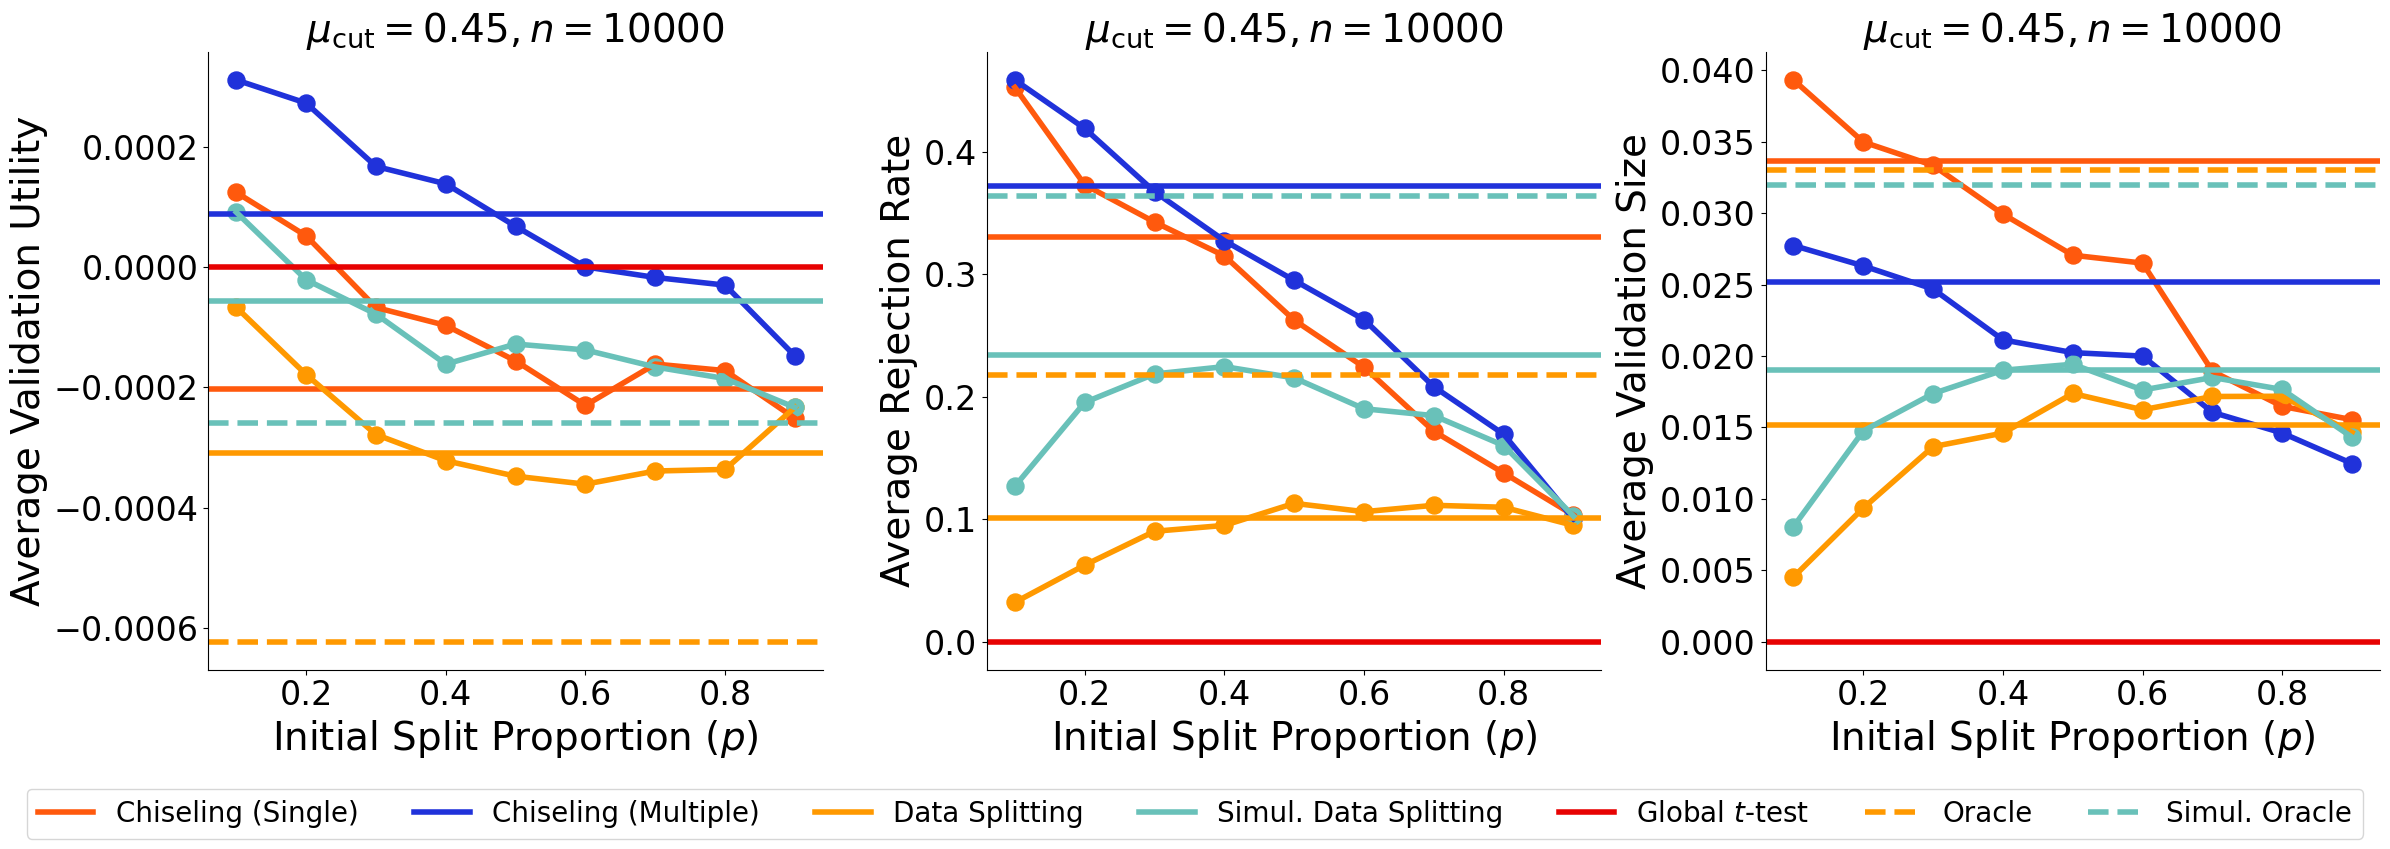

In [12]:
fig, ax = plt.subplots(1,3,figsize=(20 * 1.2,6.5 * 1.2))

PLOT_SAVELABEL = "thresh_0_45_utility_power_size"

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

# ---------------------------------------- UTILITY ---------------------------------------- #

VIZ_PROPERTY = "subgroup_utility_mean"
YLABEL = "Average Validation Utility"

for test_thresh, n in test_thresh_n_space[3:]:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.test_thresh == test_thresh]
    # Chiseling methods
    for margin_width in margin_width_settings:
        color = method_cmap[("Chiseling", margin_width)]
        method_pretty_name = full_method_pretty_name_map[("Chiseling", margin_width)]
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                     label=method_pretty_name, color=color, linewidth=LINEWIDTH)
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                        color=color, s=MARKERSIZE)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH)
    # Data splitting
    color = method_cmap["DataSplittingStrategy"]
    method_pretty_name = full_method_pretty_name_map["DataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "DataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "DataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH)
    # Simultaneous data splitting
    color = method_cmap["SimulDataSplittingStrategy"]
    method_pretty_name = full_method_pretty_name_map["SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for simultaneous data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "SimulDataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH)
    # T-test
    color = method_cmap["TTestStrategy"]
    method_pretty_name = full_method_pretty_name_map["TTestStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "TTestStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    # Oracle
    color = method_cmap["OracleStrategy"]
    method_pretty_name = full_method_pretty_name_map["OracleStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, linestyle="--", color=color, linewidth=LINEWIDTH)
    # Oracle simultaneous
    color = method_cmap["OracleSimulStrategy"]
    method_pretty_name = full_method_pretty_name_map["OracleSimulStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleSimulStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, linestyle="--", color=color, linewidth=LINEWIDTH)
    # Add title
    ax[AX0].set_title(r"$\mu_{\mathrm{cut}}" + "= {}, n = {}$".format(test_thresh, n), fontsize=TITLE_FONTSIZE)
    # Set x-labels
    ax[AX0].set_xlabel("Initial Split Proportion ($p$)", fontsize=LABEL_FONTSIZE)
    # Tick fontsize
    ax[AX0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    if HIDESPINES:
        ax[AX0].spines[['right', 'top']].set_visible(False)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

# ---------------------------------------- POWER ---------------------------------------- #

VIZ_PROPERTY = "rejected_mean"
YLABEL = "Average Rejection Rate"

for test_thresh, n in test_thresh_n_space[3:]:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.test_thresh == test_thresh]
    # Chiseling methods
    for margin_width in margin_width_settings:
        color = method_cmap[("Chiseling", margin_width)]
        method_pretty_name = full_method_pretty_name_map[("Chiseling", margin_width)]
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                     label=method_pretty_name, color=color, linewidth=LINEWIDTH)
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                        color=color, s=MARKERSIZE)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH)
    # Data splitting
    color = method_cmap["DataSplittingStrategy"]
    method_pretty_name = full_method_pretty_name_map["DataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "DataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "DataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH)
    # Simultaneous data splitting
    color = method_cmap["SimulDataSplittingStrategy"]
    method_pretty_name = full_method_pretty_name_map["SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for simultaneous data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "SimulDataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH)
    # T-test
    color = method_cmap["TTestStrategy"]
    method_pretty_name = full_method_pretty_name_map["TTestStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "TTestStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    # Oracle
    color = method_cmap["OracleStrategy"]
    method_pretty_name = full_method_pretty_name_map["OracleStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, linestyle="--", color=color, linewidth=LINEWIDTH)
    # Oracle simultaneous
    color = method_cmap["OracleSimulStrategy"]
    method_pretty_name = full_method_pretty_name_map["OracleSimulStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleSimulStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, linestyle="--", color=color, linewidth=LINEWIDTH)
    # Add title
    ax[AX0].set_title(r"$\mu_{\mathrm{cut}}" + "= {}, n = {}$".format(test_thresh, n), fontsize=TITLE_FONTSIZE)
    # Set x-labels
    ax[AX0].set_xlabel("Initial Split Proportion ($p$)", fontsize=LABEL_FONTSIZE)
    # Tick fontsize
    ax[AX0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    if HIDESPINES:
        ax[AX0].spines[['right', 'top']].set_visible(False)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

# ---------------------------------------- Size ---------------------------------------- #

VIZ_PROPERTY = "region_mass_mean"
YLABEL = "Average Validation Mass"

for test_thresh, n in test_thresh_n_space[3:]:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.test_thresh == test_thresh]
    # Chiseling methods
    for margin_width in margin_width_settings:
        color = method_cmap[("Chiseling", margin_width)]
        method_pretty_name = full_method_pretty_name_map[("Chiseling", margin_width)]
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                     label=method_pretty_name, color=color, linewidth=LINEWIDTH)
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                        color=color, s=MARKERSIZE)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH)
    # Data splitting
    color = method_cmap["DataSplittingStrategy"]
    method_pretty_name = full_method_pretty_name_map["DataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "DataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "DataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH)
    # Simultaneous data splitting
    color = method_cmap["SimulDataSplittingStrategy"]
    method_pretty_name = full_method_pretty_name_map["SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for simultaneous data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "SimulDataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH)
    # T-test
    color = method_cmap["TTestStrategy"]
    method_pretty_name = full_method_pretty_name_map["TTestStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "TTestStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    # Oracle
    color = method_cmap["OracleStrategy"]
    method_pretty_name = full_method_pretty_name_map["OracleStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, linestyle="--", color=color, linewidth=LINEWIDTH)
    # Oracle simultaneous
    color = method_cmap["OracleSimulStrategy"]
    method_pretty_name = full_method_pretty_name_map["OracleSimulStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleSimulStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, linestyle="--", color=color, linewidth=LINEWIDTH)
    # Add title
    ax[AX0].set_title(r"$\mu_{\mathrm{cut}}" + "= {}, n = {}$".format(test_thresh, n), fontsize=TITLE_FONTSIZE)
    # Set x-labels
    ax[AX0].set_xlabel("Initial Split Proportion ($p$)", fontsize=LABEL_FONTSIZE)
    # Tick fontsize
    ax[AX0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    if HIDESPINES:
        ax[AX0].spines[['right', 'top']].set_visible(False)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

# Global formatting
ax[0].set_ylabel("Average Validation Utility", fontsize=LABEL_FONTSIZE)
ax[1].set_ylabel("Average Rejection Rate", fontsize=LABEL_FONTSIZE)
ax[2].set_ylabel("Average Validation Size", fontsize=LABEL_FONTSIZE)
# ax[-1].legend(fontsize=LEGEND_FONTSIZE)
handles, _ = ax[1].get_legend_handles_labels()
fig.legend(handles=handles, fontsize=LEGEND_FONTSIZE, loc='upper center',
           bbox_to_anchor=(0.5, 0), fancybox=True, ncols=7)
plt.tight_layout()

plt.show()